In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from linecache import getline

In [2]:
def parseNumVehicles(line):
    x = re.findall(r"No of trucks: [0-9]", line)
    return int(x[0][-1])

def parseForNum(line):
    x = re.findall(r"[0-9]+", line)
    return int(x[0])

def parseCoords(line):
    x = line.split()
#     print([x[1], x[2]])
    return [int(x[1]), int(x[2])]

def parseDemand(line):
    x = line.split()
#     print(x[0], x[1])
    return [int(x[0]), int(x[1])]

In [3]:
a = np.loadtxt(r"A-n32-k5.txt", delimiter='\n', dtype=str)
    
COORD_FLAG = False
DEMAND_FLAG = False
xc = []
yc = []
q = {}
    
fh = open("A-n32-k5.txt",'r')
for i,line in enumerate(fh):
    if "CAPACITY" in line:
        Q = parseForNum(line)
    elif "COMMENT" in line:
        num = parseNumVehicles(line)
        p = num + 1
#         p = [r for r in range(1, num)]
    elif "DIMENSION" in line:
        n = int(parseForNum(line)) - 1 # number of clients
    elif "NODE_COORD_SECTION" in line:
        COORD_FLAG = True
    elif "DEMAND_SECTION" in line:
        COORD_FLAG = False
        DEMAND_FLAG = True
    elif "DEPOT_SECTION" in line:
        DEMAND_FLAG = False
        print()
    elif COORD_FLAG:
        coord = parseCoords(line)
        xc.append(coord[0])
        yc.append(coord[1])
    elif DEMAND_FLAG:
        demand = parseDemand(line)
        q[demand[0]] = demand[1]
fh.close()

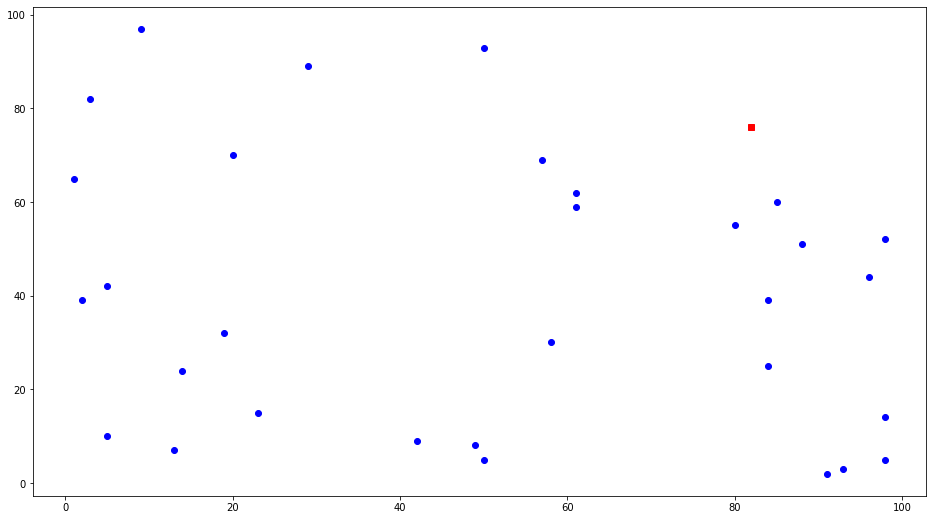

In [4]:
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')

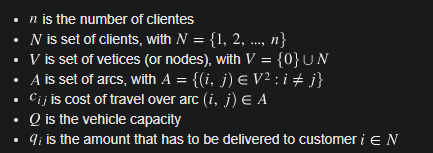

In [5]:
N = [i for i in range(1, n+1)] # Number of clients
V = [0] + N # Number of nodes (including depot)
A = [(i, j, k) for i in V for j in V if i != j for k in range(p)] 
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j, k in A} # cost
U = [(i, k) for i in N for k in range(p)]

In [6]:
from gurobipy import Model, GRB, quicksum

In [7]:
mdl = Model('CVRP')
u = mdl.addVars(N, vtype=GRB.CONTINUOUS)

Academic license - for non-commercial use only - expires 2021-03-18
Using license file C:\Users\BigBadBraddy\gurobi.lic


In [8]:
# for a in A:
#     i = a[0]
#     j = a[1]
#     for k in range(1, p):
#         x[i, j, k] = mdl.addVars(A, vtype=GRB.BINARY)
#         x[j, i, k] = x[i, j, k]

# for a in A:

x = mdl.addVars(A, vtype=GRB.BINARY)
mdl.update()


In [9]:
# obj = quicksum( c[i, j] / 2 * x[i, j, k] for i in range(n) for j in range(n) for k in range(p) if i != j)
# mdl.setObjective(obj)
# sum = 0
# mdl.modelSense = GRB.MINIMIZE
# for k in range(1, p):
#     for i in N:
#         for j in N:
#             if i != j:
#                 sum += c[i, j] * x[i, j, k] 
    
# mdl.setObjective(quicksum(c[i, j] * x[i, j, k] for k in range(p) for i in N for j in N))
# mdl.setObjective(sum)


mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(c[i, j] * x[i, j, k] for i, j, k in A))

mdl.update()

## 0. There is no travel from a node to itself

In [10]:
# mdl.addConstrs(quicksum(x[i, i, k] for k in range(p)) == 0 for i in N)
# mdl.update()

print(N)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


## 1. Vehicle leaves node that it enters

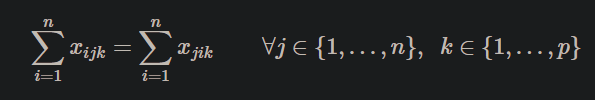

In [11]:
mdl.addConstrs(quicksum(x[i, j, k] for i in N if i != j) == quicksum(x[j, i, k] for i in N if i != j) for j in N for k in range(p))
mdl.update()


## 2. Ensure that every node is entered once

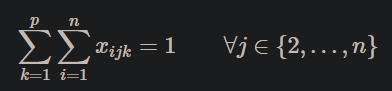

In [12]:
mdl.addConstrs(quicksum(x[i, j, k] for k in range(p) for i in N if i != j) == 1 for j in range(2, n))
mdl.update()

## 3. Every vehicle leaves the depot

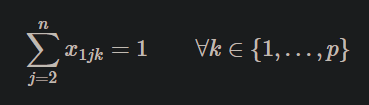

In [13]:
mdl.addConstrs(quicksum(x[1, j, k] for j in range(2, n+1)) == 1 for k in range(p))
mdl.update()

## 4. Capacity constraint

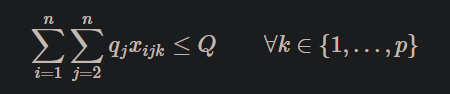

In [14]:
mdl.addConstrs(quicksum(q[j]*x[i, j, k] for i in N for j in N if j >= 2 and i != j) <= Q for k in range(p))
# #  in range(2, n+1)
mdl.update()

## 5. Eliminating subtours

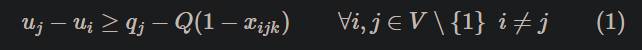

In [15]:
print(u)

{1: <gurobi.Var C0>, 2: <gurobi.Var C1>, 3: <gurobi.Var C2>, 4: <gurobi.Var C3>, 5: <gurobi.Var C4>, 6: <gurobi.Var C5>, 7: <gurobi.Var C6>, 8: <gurobi.Var C7>, 9: <gurobi.Var C8>, 10: <gurobi.Var C9>, 11: <gurobi.Var C10>, 12: <gurobi.Var C11>, 13: <gurobi.Var C12>, 14: <gurobi.Var C13>, 15: <gurobi.Var C14>, 16: <gurobi.Var C15>, 17: <gurobi.Var C16>, 18: <gurobi.Var C17>, 19: <gurobi.Var C18>, 20: <gurobi.Var C19>, 21: <gurobi.Var C20>, 22: <gurobi.Var C21>, 23: <gurobi.Var C22>, 24: <gurobi.Var C23>, 25: <gurobi.Var C24>, 26: <gurobi.Var C25>, 27: <gurobi.Var C26>, 28: <gurobi.Var C27>, 29: <gurobi.Var C28>, 30: <gurobi.Var C29>, 31: <gurobi.Var C30>}


In [21]:
# mdl.addConstrs(quicksum(u[j] - u[i] for j in N) >= quicksum(q[j] - Q*(1 - x[i, j, k]) for j in N if i != j for k in range(p)) for i in N)
mdl.addConstrs((x[i, j, k] == 0) >> (u[i]+q[j] <= u[j]) for i, j, k in A if i != 0 and j != 0)
# mdl.addConstrs((x[i, j] == 1) >> (u[i]+q[j] == u[j]) for i, j in A if i != 0 and j != 0)
mdl.update()

## 6. Eliminating subtours

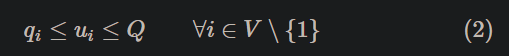

In [22]:
mdl.addConstrs(u[i] >= q[i] for i in N)
mdl.addConstrs(u[i] <= Q for i in N)
mdl.update()

In [23]:
mdl.Params.MIPGap = 0.1
mdl.Params.TimeLimit = 60  # seconds
mdl.optimize()

Parameter MIPGap unchanged
   Value: 0.1  Min: 0.0  Max: inf  Default: 0.0001
Parameter TimeLimit unchanged
   Value: 60.0  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 351 rows, 5983 columns and 22084 nonzeros
Model fingerprint: 0xff71254a
Model has 11160 general constraints
Variable types: 31 continuous, 5952 integer (5952 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve added 27776 rows and 10434 columns
Presolve time: 0.24s

Explored 0 nodes (0 simplex iterations) in 0.25 seconds
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [24]:
active_arcs = [a for a in A if x[a].x > 0.99]


print(active_arcs)

AttributeError: Unable to retrieve attribute 'x'

In [ ]:
plt.rcParams["figure.figsize"] = [16,9]
for i, j, k in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')